# Machine Learning for Social Media-Based Depression Analysis

## Business Understanding

Mental health is an urgent issue globally, with depression affecting millions of individuals across all demographics. The internet, and particularly social media, has become a place where people often express their struggles, including depression. Early detection of depression symptons can be crucial in providing timely support or intervention. This project’s goal is to leverage data science to better understand and detect depressive expressions in online platforms, potentially paving the way for more proactive mental health support. Given the widespread use of platforms like Reddit, this research could benefit individuals by increasing awareness and intervention opportunities


## Data Understanding

Datasource: https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data

The dataset already includes several key features that can be used to analyze and predict depression indicators based on Reddit posts. Specifically, the data has 7 key columns:

subreddit : The subreddit where each post was made, with posts from "Depression" and "SuicideWatch" labeled as 1 for depression and posts from other subreddits labeled as 0 (non-depression).

title: The title of the Reddit post.

body: The full text of the Reddit post, which may contain valuable information for understanding the context, tone, and possible indicators of depression.

upvotes: Number of upvotes each post received, which may indicate the post's visibility or resonance with the community.

created_utc: The timestamp of when the post was created in UTC, which can help in analyzing temporal trends.

num_comments: The number of comments on each post, which could provide insights into community engagement.

label: The target variable indicating depression (1) or non-depression (0) based on subreddit. .... The raw data was collected from five Reddit subreddits (sub topics), categorized based on their content. These included: Teenagers, Depression, SuicideWatch, DeepThoughts, Happy

Since the data is already collected from Reddit, with over 6 million rows, further data acquisition may not be necessary. Infact, the team proposes reducing the dataset to about 500,000 rows for the purpose of this project(and to save our laptops). However, if additional data is needed, we could plan to scrape Reddit for more recent posts using a tool that we could identify through further research, provided we comply with Reddit's data collection policies and privacy standards.


In [31]:
#import libraries needed
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
import string

from scipy.sparse import csr_matrix

In [3]:
#Load the dataset to use 
#data = pd.read_csv(file_path)  # 
data = pd.read_csv(r"C:\Users\admin\Documents\Flatiron\Phase-5\final_project\Data\reduced_reddit.csv", index_col=False)
data.head(10)  # Display the first few rows of the dataframe


,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,NaN,4.0,1.619357e+09,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,1.554103e+09,NaN,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,1.649342e+09,12.0,0.0
3,teenagers,This isn't going to work out,NaN,236.0,1.417630e+09,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,1.569280e+09,4.0,0.0
5,teenagers,"Phew , close one",NaN,11.0,1.587389e+09,NaN,0.0
6,teenagers,Listen to my favorite song part 2 🤩🤩🤩,https://youtu.be/MtN1YnoL46Q,9.0,1.610744e+09,11.0,0.0
7,teenagers,Hard core cuddling,#moans,41.0,1.625997e+09,19.0,0.0
8,teenagers,Don't communicate with women.,I watched my friend go to high five a girl and...,7.0,1.557873e+09,11.0,0.0
9,teenagers,Do you guys just ever want to be left alone?,"Just, after a bunch of socialising I want to c...",5.0,1.511478e+09,10.0,0.0


In [4]:
#check the dataset information 
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  94297 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [5]:
#check on the description of numerical datatypes
data.describe()

,upvotes,created_utc,num_comments,label
count,98826.000000,9.882600e+04,94297.000000,98826.000000
mean,62.315555,1.566569e+09,15.217069,0.194443
std,937.347581,6.977745e+07,71.638197,0.395773
min,4.000000,1.202084e+09,1.000000,0.000000
25%,5.000000,1.552254e+09,4.000000,0.000000
50%,7.000000,1.578218e+09,7.000000,0.000000
75%,11.000000,1.611584e+09,14.000000,0.000000
max,62899.000000,1.672531e+09,7880.000000,1.000000


## Data Cleaning

In [6]:
#check to see if there are null values in percentage form
data.isnull().sum() / len(data) * 100

subreddit        0.000000
title            0.000000
body            18.674236
upvotes          0.000000
created_utc      0.000000
num_comments     4.582802
label            0.000000
dtype: float64

The dataset has some columns that have null values, namely body and num_comments. The latter has 18% of the rows with missing values while the former has averagely 5% of missing values which we can drop these missing rows as it makes a small percentage of the data. 
For the body column, I will impute the missing values by filling with the text "no content".  

In [7]:
# Now you can fill missing values in 'body' column for the new 'data_main'
data['num_comments'] = data['num_comments'].fillna(0)

# Check the DataFrame info again to confirm the change
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subreddit     98826 non-null  object 
 1   title         98826 non-null  object 
 2   body          80371 non-null  object 
 3   upvotes       98826 non-null  float64
 4   created_utc   98826 non-null  float64
 5   num_comments  98826 non-null  float64
 6   label         98826 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.3+ MB


In [8]:
data.isnull().sum()

subreddit           0
title               0
body            18455
upvotes             0
created_utc         0
num_comments        0
label               0
dtype: int64

### Handling missing values in body

In [37]:
# Droping rows with missing values in the 'body' column
data = data.dropna(subset=['body']).reset_index(drop=True)

# Checking for null values and confirming data shape after cleaning to ensure nomissing values
data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98826 entries, 0 to 98825
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subreddit        98826 non-null  object 
 1   title            98826 non-null  object 
 2   body             98826 non-null  object 
 3   upvotes          98826 non-null  float64
 4   num_comments     98826 non-null  float64
 5   label            98826 non-null  float64
 6   processed_title  98826 non-null  object 
 7   processed_body   98826 non-null  object 
dtypes: float64(3), object(5)
memory usage: 6.0+ MB


(None, (98826, 8))

In [12]:
# Convert 'created_utc' column from UTC epoch time to datetime
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')

# To see the updated DataFrame

data

,subreddit,title,body,upvotes,created_utc,num_comments,label
0,teenagers,Day 18 of doing 50 push-ups,No content,4.0,2021-04-25 13:25:39,4.0,0.0
1,teenagers,There isn’t a better feeling than finishing yo...,Then your teacher hits you with that “ Good jo...,7.0,2019-04-01 07:19:57,0.0,0.0
2,teenagers,LMAOOO I can only get this guy to talk to me i...,Yeahhh maybe not babe,4.0,2022-04-07 14:35:00,12.0,0.0
3,teenagers,This isn't going to work out,No content,236.0,2014-12-03 18:12:52,33.0,0.0
4,teenagers,Am I the only guy who found it hurtful as a ch...,\n\nLike... why? How is that funny? How does ...,6.0,2019-09-23 23:07:59,4.0,0.0
...,...,...,...,...,...,...,...
98821,depression,Has anyone ever had any problems with gangs?,I don't care if my grammer isn't good so dont ...,8.0,2019-05-17 08:30:19,1.0,1.0
98822,SuicideWatch,"Moments away from killing myself, not even bot...","I don't want to talk about my problems, I don'...",12.0,2012-10-20 17:24:21,8.0,1.0
98823,SuicideWatch,I've grown used to being like this for years.,"I'm not suicidal at the moment, in fact I feel...",14.0,2015-05-19 22:19:26,4.0,1.0
98824,depression,This speech from The Lord of the Rings really ...,"""It's like in the great stories, Mr. Frodo. Th...",323.0,2012-12-16 15:44:18,28.0,1.0


## Exploratory Data Analysis

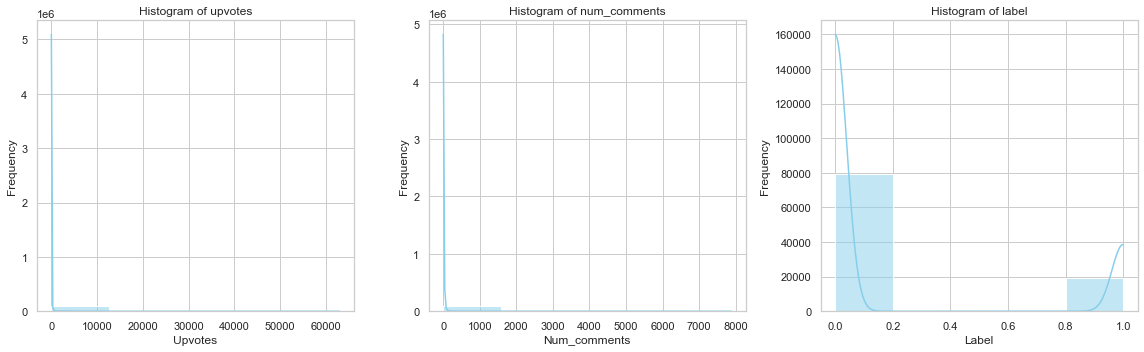

In [13]:
#Visualize the frequency distribution of values using histograms and to identify outliers using the box plots- for upvotes and num_comments

sns.set(style="whitegrid")
numeric_columns = ['upvotes', 'num_comments', 'label']

# Set up the subplot grid
fig, axes = plt.subplots(1, len(numeric_columns), figsize=(16, 5))

for i, col in enumerate(numeric_columns):
    sns.histplot(data[col], bins=5, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

teenagers       78251
depression      11672
SuicideWatch     7544
happy             995
DeepThoughts      364
Name: subreddit, dtype: int64
0.0    79610
1.0    19216
Name: label, dtype: int64


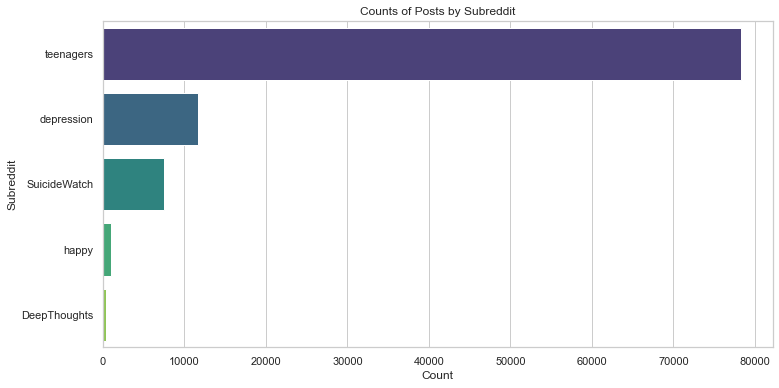

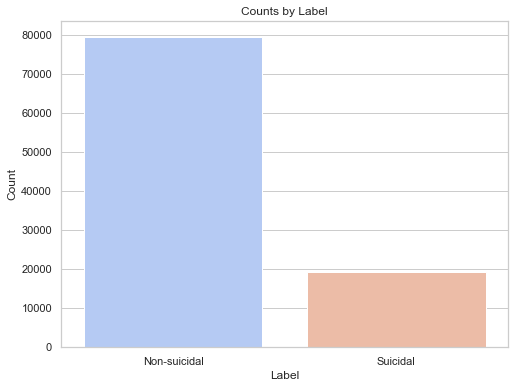

In [14]:
#Frequency of categorical columns

# Frequency of 'subreddit' column
print(data['subreddit'].value_counts())

# Frequency of 'label' column
print(data['label'].value_counts())

# Set style
sns.set(style="whitegrid")

# Plot the counts for 'subreddit' column
plt.figure(figsize=(12, 6))
sns.countplot(data=data, y='subreddit', order=data['subreddit'].value_counts().index, palette='viridis')
plt.title('Counts of Posts by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.show()

# Plot the counts for 'label' column
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='label', palette='coolwarm')
plt.title('Counts by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-suicidal', 'Suicidal'])
plt.show()


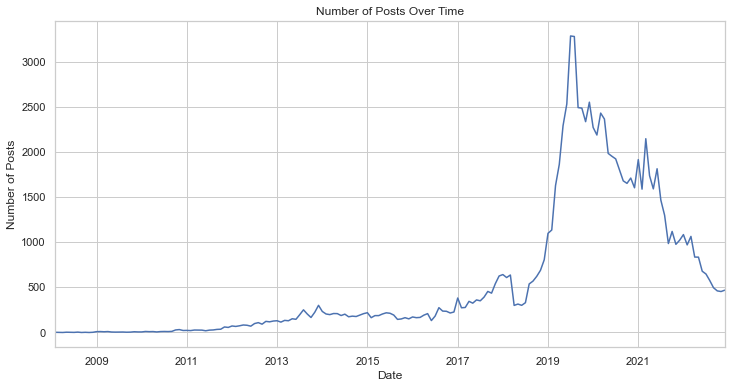

In [15]:
# Plot number of posts over time
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')
data.set_index('created_utc', inplace=True)

# Plot number of posts per month
data.resample('M').size().plot(figsize=(12, 6))
plt.title('Number of Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

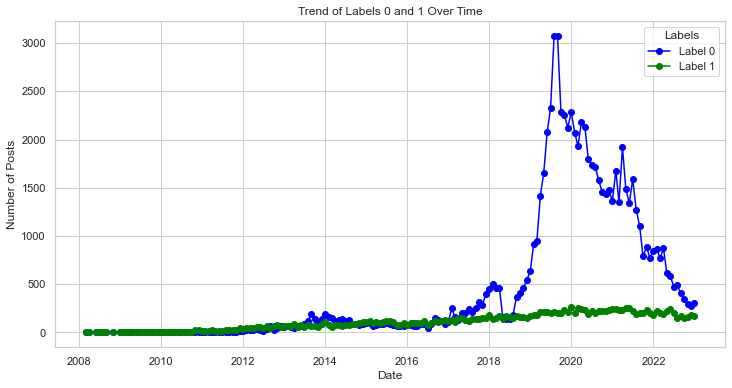

In [16]:
# Resample the data by month (change this to 'W' for weekly or 'D' for daily)
label_trend = data.resample('M')['label'].value_counts().unstack().fillna(0)

# Plot the trend over time for both labels
plt.figure(figsize=(12, 6))
plt.plot(label_trend.index, label_trend[0], label='Label 0', color='blue', marker='o')
plt.plot(label_trend.index, label_trend[1], label='Label 1', color='green', marker='o')

# Adding titles and labels
plt.title('Trend of Labels 0 and 1 Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Labels')
plt.grid(True)

# Show the plot
plt.show()

## Bivariate Analysis

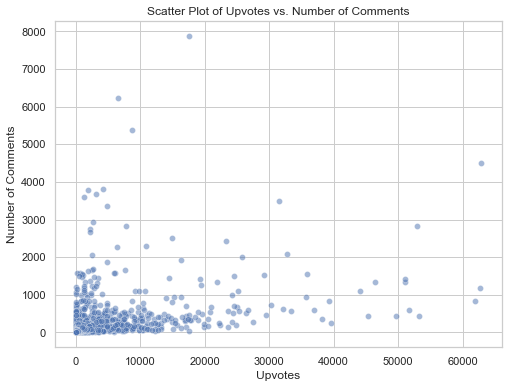

In [17]:
#Numerical vs. Numerical (Scatter plot and correlation matrix)
#Scatter Plot - Shows the relationship between two numerical variables, upvotes and num_comments.

# Scatter plot for numerical variables
plt.figure(figsize=(8, 6))
sns.scatterplot(x='upvotes', y='num_comments', data=data, alpha=0.5)
plt.title("Scatter Plot of Upvotes vs. Number of Comments")
plt.xlabel("Upvotes")
plt.ylabel("Number of Comments")
plt.show()



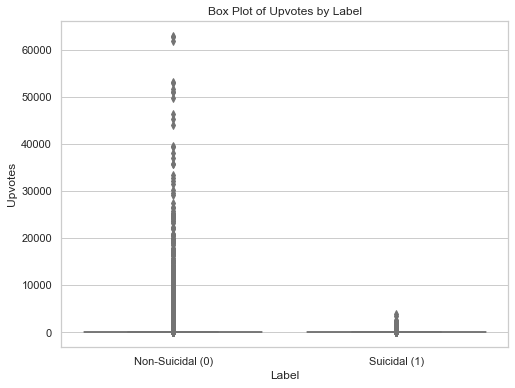

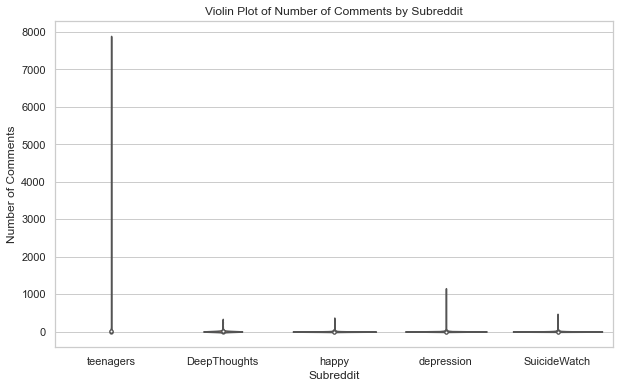

In [18]:
# Numerical vs. Categorical (Box plot and Violin plot)
# Box plot of 'upvotes' by 'label'
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='upvotes', data=data, palette='pastel')
plt.title("Box Plot of Upvotes by Label")
plt.xlabel("Label")
plt.ylabel("Upvotes")
plt.xticks(ticks=[0, 1], labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

# Violin plot of 'num_comments' by 'subreddit'
plt.figure(figsize=(10, 6))
sns.violinplot(x='subreddit', y='num_comments', data=data, palette='muted')
plt.title("Violin Plot of Number of Comments by Subreddit")
plt.xlabel("Subreddit")
plt.ylabel("Number of Comments")
plt.show()

Crosstab of Subreddit by Label:
label           0.0    1.0
subreddit                 
DeepThoughts    364      0
SuicideWatch      0   7544
depression        0  11672
happy           995      0
teenagers     78251      0


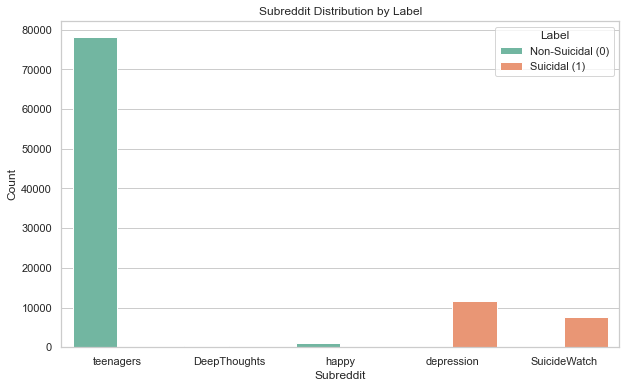

In [19]:
# Crosstab between 'subreddit' and 'label'
crosstab = pd.crosstab(data['subreddit'], data['label'])
print("Crosstab of Subreddit by Label:")
print(crosstab)

# Bar plot for 'subreddit' and 'label'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="subreddit", hue="label", palette="Set2")
plt.title("Subreddit Distribution by Label")
plt.xlabel("Subreddit")
plt.ylabel("Count")
plt.legend(title="Label", loc='upper right', labels=["Non-Suicidal (0)", "Suicidal (1)"])
plt.show()

## Multivariate Analysis

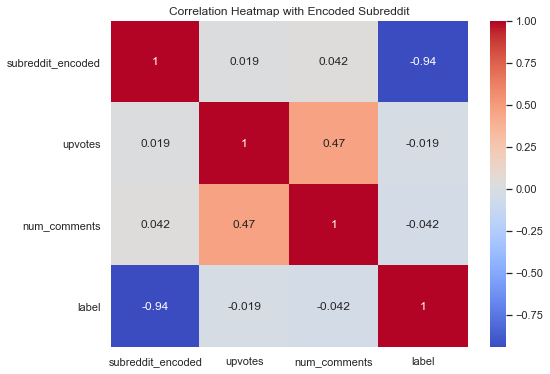

In [ ]:
# Convert the 'subreddit' column to numeric using label encoding
data['subreddit_encoded'] = LabelEncoder().fit_transform(data['subreddit'])

# Now include the encoded 'subreddit' in the heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data[['subreddit_encoded', 'upvotes', 'num_comments', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Encoded Subreddit')
plt.show()

# Sentiment Analysis

In [29]:
# Initializing stopwords, punctuation, and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#define a class TextPreprocessor that conforms to scikit-learn’s transformer API
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # No fitting required for this transformer

    def transform(self, X, y=None):
        return X.apply(self._preprocess_text)
    def _preprocess_text(self, text):
        if pd.isnull(text):
            return ''  # Return empty string for missing values
        text = text.lower()  # Lowercase
        text = ''.join([char for char in text if char not in string.punctuation])  # Remove punctuation
        tokens = word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize
        return ' '.join(tokens)  # Join tokens back into string


# Instantiate TextPreprocessor
text_preprocessor = TextPreprocessor()

# Apply the text preprocessor to 'title' and 'body' columns
data['processed_title'] = text_preprocessor.transform(data['title'])
data['processed_body'] = text_preprocessor.transform(data['body'])

# Display the processed data
data[['processed_title', 'processed_body']]

,processed_title,processed_body
created_utc,,
2021-04-25 13:25:39,day 18 50 pushup,content
2019-04-01 07:19:57,’ better feeling finishing science paper 1am d...,teacher hit “ good job everyone draft final co...
2022-04-07 14:35:00,lmaooo get guy talk talk god💖💖,yeahhh maybe babe
2014-12-03 18:12:52,isnt going work,content
2019-09-23 23:07:59,guy found hurtful child movie kid female chara...,like funny deserve better male character kick ...
...,...,...
2019-05-17 08:30:19,anyone ever problem gang,dont care grammer isnt good dont even bring se...
2012-10-20 17:24:21,moment away killing even bothering make throw ...,dont want talk problem dont want talk problem ...
2015-05-19 22:19:26,ive grown used like year,im suicidal moment fact feel great right time ...


In [ ]:
# TF-IDF give higher weights to words that are less common across documents.

# Apply TF-IDF to the title and body columns separately
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # limiting to top 10,000 features_to manage vocabulary size


# Using the processed title and body columns 
tfidf_title = tfidf_vectorizer.fit_transform(data['processed_title'])
tfidf_body = tfidf_vectorizer.fit_transform(data['processed_body'])

# keeping these as sparse matrices which we can also concatenate directly if needed for model input
combined_features = csr_matrix(tfidf_title) + csr_matrix(tfidf_body) # in sparse format, to save memory

### Token analysis

In [34]:
#Examining the top words by TF-IDF Scores

# Display the top terms with the highest TF-IDF scores
tfidf_sum = combined_features.sum(axis=0)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_sum.A1})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Displaying the top 50 terms with the highest TF-IDF scores
tfidf_df.head(50)

,word,tfidf_score
2104,content,18479.583237
4559,im,2953.257195
9638,want,2922.257239
5264,like,2678.515789
4572,immediate,1891.458108
2835,dont,1866.912519
3506,feel,1790.574042
5081,know,1762.206545
3930,get,1679.813243
5202,legacy,1458.149602


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

# Spliting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data['body'], data['label'], test_size=0.2, random_state=42)

# Creating a pipeline with TF-IDF Vectorizer and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)),
    ('clf', LogisticRegression(solver='liblinear', random_state=42))
])

# Training the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
report = classification_report(y_test, y_pred, target_names=['Non-Depression', 'Depression'])
report


'                precision    recall  f1-score   support\n\nNon-Depression       0.94      0.98      0.96     15998\n    Depression       0.89      0.72      0.79      3768\n\n      accuracy                           0.93     19766\n     macro avg       0.91      0.85      0.88     19766\n  weighted avg       0.93      0.93      0.93     19766\n'

### Performing hyperparameter tunning
- This will improve performance of our model

In [39]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'tfidf__max_df': [0.9, 0.95, 1.0],
    'tfidf__min_df': [1, 5, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],  # Unigrams and bigrams
    'clf__C': [0.1, 1, 10],  # Regularization strength
    'clf__penalty': ['l2']  # 'liblinear' solver supports only 'l2'
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score


Fitting 3 folds for each of 54 candidates, totalling 162 fits


({'clf__C': 10,
  'clf__penalty': 'l2',
  'tfidf__max_df': 0.9,
  'tfidf__min_df': 1,
  'tfidf__ngram_range': (1, 2)},
 0.9223149310039737)